
# Latent ODE Training

This notebook performs training of Latent ODE models on sine wave data.

In [1]:
import sys, os
sys.path.append(os.path.abspath('..'))

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0')

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils import gpu_f, to_np, RunningAverageMeter

## Data Generation: Sine Waves


In [2]:
data_path = "./Data/Train/sine_data_2021-05-30 12:04:57.968522"
generator = torch.load(data_path)['generator']

In [3]:
train_time, train_data = generator.get_train_set()
val_time, val_data = generator.get_val_set()

train_data = train_data.reshape(len(train_data), -1, 1)
val_data = val_data.reshape(len(val_data), -1, 1)

train_data_tt = gpu_f(train_data)
train_time_tt = gpu_f(train_time)

val_data_tt = gpu_f(val_data)
val_time_tt = gpu_f(val_time)

In [4]:
class SineSet(Dataset):
    def __init__(self, data, time):
        self.data = data
        self.time = time
    def __len__(self):
        return len(self.data)
    def __getitem__(self, idx):
        return self.data[idx], self.time
    
train_dataset = SineSet(train_data_tt, train_time_tt)
val_dataset = SineSet(val_data_tt, val_time_tt)

train_loader = DataLoader(train_dataset, batch_size = 256, shuffle=True)
val_loader = DataLoader(train_dataset, batch_size = len(val_dataset))

# Training loop

In [5]:
from model import LatentNeuralODEBuilder

model_args = {
    'obs_dim': 1,
    'rec_latent_dim': 8,
    'node_latent_dim': 4,
    
    'rec_gru_unit': 100,
    'rec_node_hidden': 100,
    'rec_node_layer': 1,
    'rec_node_act': 'Tanh',
    
    'latent_node_hidden': 100,
    'latent_node_layer': 1,
    'latent_node_act': 'Tanh',
    
    'dec_type': 'NN',
    'dec_hidden': 100,
    'dec_layer': 1,
    'dec_act': 'ReLU',
}

model = LatentNeuralODEBuilder(**model_args).build_latent_node().to(device)

In [6]:
from train import TrainingLoop
from visualize_sine import plot_training_sine

main = TrainingLoop(model, train_loader, val_loader, plot_training_sine)

In [7]:
from torch.optim.lr_scheduler import ExponentialLR

lr = 1e-3

parameters = (model.parameters())
optimizer = optim.Adamax(parameters, lr=lr)
scheduler = ExponentialLR(optimizer, 0.98)

In [8]:
from augment import aug_add_noise, aug_subsample, aug_crop_start

aug_args = {
    'crop_min': 20,
    'sample_min': 20,
    'noise_var': 0.03,
}

train_args = {
    'max_epoch': 500,
    'l_std': 1,
    'kl_burn': 50,
    'clip_norm': 5,
    'model_atol': 1e-4,
    'model_rtol': 1e-3,
    'aug_methods': [aug_add_noise, aug_subsample, aug_crop_start],
    'aug_args': aug_args,
    'plt_args': {'n_plot': 3},
}

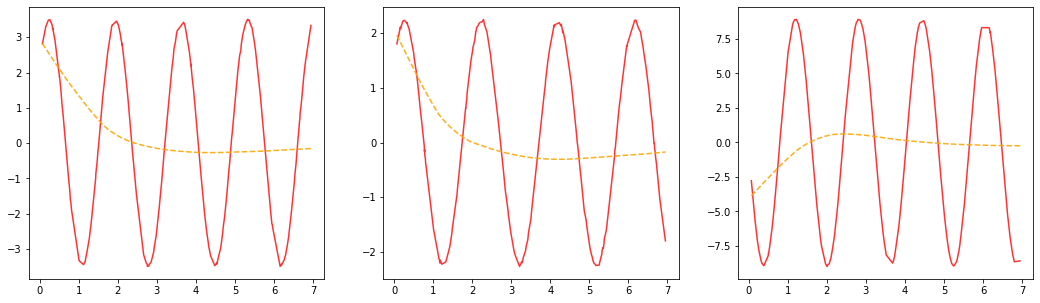

Current LR: [0.00098]


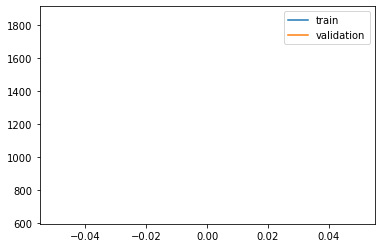

Epoch: 1, Train ELBO: -657.147, Val ELBO: -1855.100


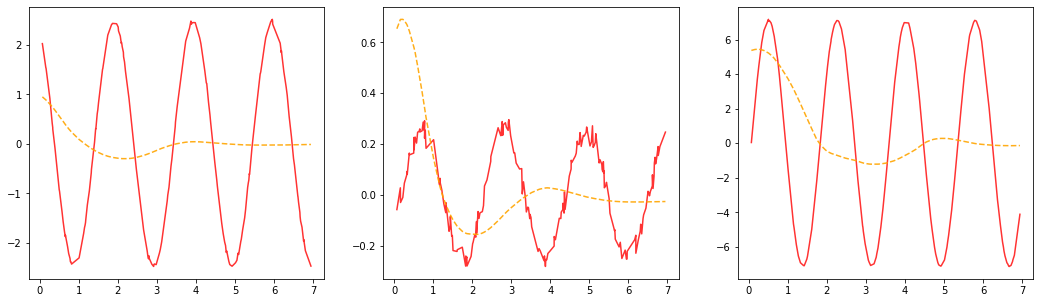

Current LR: [0.0009603999999999999]


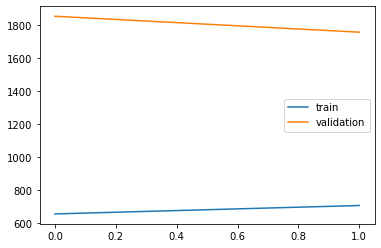

Epoch: 2, Train ELBO: -708.078, Val ELBO: -1854.134


KeyboardInterrupt: 

In [9]:
main.train(optimizer, train_args, scheduler, plt_traj=True, plt_loss=True)

In [ ]:
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'data_path': data_path,
    'model_args': model_args,
    'train_args': train_args,
    'aug_args': aug_args,
}, './Models/sine_lode_{}'.format(datetime.now()))